In [36]:
!pip3 install opencv-python

In [1]:
import cv2
import os
import numpy as np
import pickle
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import seaborn as sns

# Load and Preprocess the Dataset

In [2]:
def load_dataset(dataset_path):
    images = []
    labels = []
    for emotion in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion)
        for image_filename in os.listdir(emotion_path):
            image_path = os.path.join(emotion_path, image_filename)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(emotion)
    return images, labels

dataset_path = "dataset"
images, labels = load_dataset(dataset_path)

In [3]:
def load_subset_of_dataset(dataset_path, subset_size=5):
    images = []
    labels = []

    for emotion in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion)
        for i, image_filename in enumerate(os.listdir(emotion_path)):
            if i >= subset_size:
                break
            image_path = os.path.join(emotion_path, image_filename)
            image = cv2.imread(image_path)
            images.append(image)
            labels.append(emotion)

    return images, labels

dataset_path = "dataset"
subset_size = 5

subset_images, subset_labels = load_subset_of_dataset(dataset_path, subset_size)

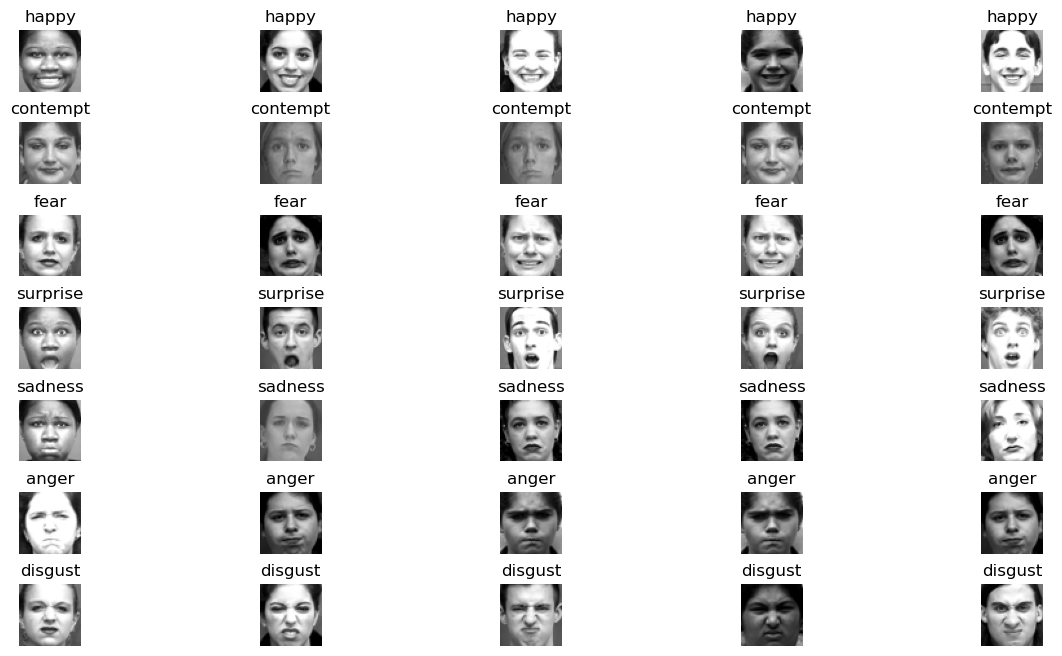

In [4]:
num_columns = 5

num_images = len(subset_images)
num_rows = (num_images + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 8))

axes = axes.flatten()

for i in range(num_images):
    image = subset_images[i]
    label = subset_labels[i]

    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(label)
    axes[i].axis('off')

for i in range(num_images, num_rows * num_columns):
    fig.delaxes(axes[i])

plt.subplots_adjust(hspace=0.5)
plt.show()

# Preprocess the Images

In [5]:
def preprocess_image(image, target_size=(84, 128)):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(gray_image, target_size)
    return resized_image

preprocessed_images = [preprocess_image(image) for image in images]

In [6]:
def preprocess_image_CH(image, target_size=(84, 128)):
    resized_image = cv2.resize(image, target_size)
    return resized_image

preprocessed_images_CH = [preprocess_image_CH(image) for image in images]

# Feature Extraction - HOG (Histogram of Oriented Gradients)

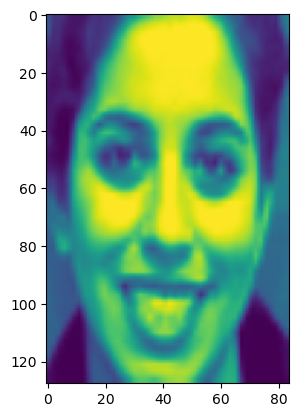

In [7]:
def extract_hog_features(image):
    features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    return features

hog_features = [extract_hog_features(image) for image in preprocessed_images]

image = preprocessed_images[1]

plt.imshow(image)

plt.show()

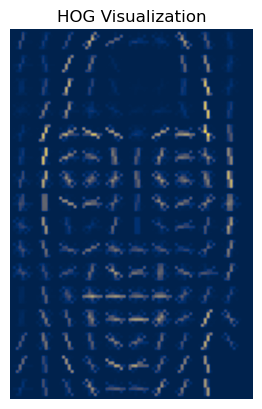

In [8]:
feature, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
plt.imshow(_, cmap='cividis')
plt.title("HOG Visualization")
plt.axis('off')
plt.show()

# Feature Extraction - Local Binary Patterns (LBP)

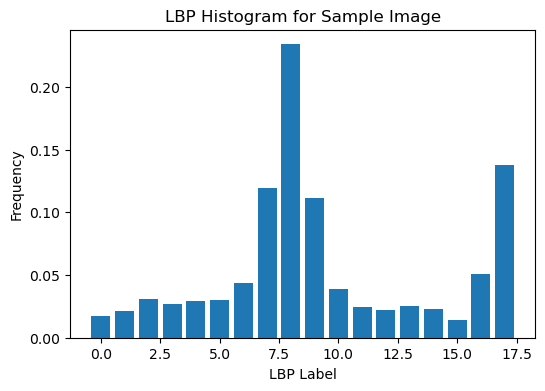

In [9]:
from skimage import feature

radius = 3
n_points = 16
method = 'uniform'

lbp_features = []

for image in preprocessed_images:
    lbp_image = feature.local_binary_pattern(image, n_points, radius, method)
    
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    lbp_features.append(hist)

sample_lbp_image = lbp_features[1]

plt.figure(figsize=(6, 4))
plt.bar(range(0, len(sample_lbp_image)), sample_lbp_image)
plt.title("LBP Histogram for Sample Image")
plt.xlabel("LBP Label")
plt.ylabel("Frequency")
plt.show()

# Feature Extraction - Colour Histograms

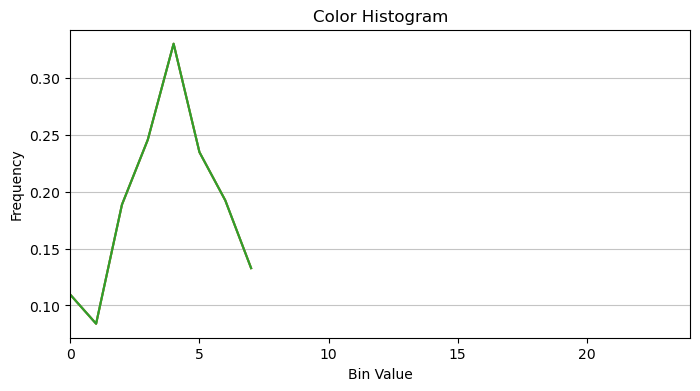

In [10]:
histograms = []

bins = 8

for image in preprocessed_images_CH:
    b_hist = cv2.calcHist([image], [0], None, [bins], [0, 256])
    g_hist = cv2.calcHist([image], [1], None, [bins], [0, 256])
    r_hist = cv2.calcHist([image], [2], None, [bins], [0, 256])

    histogram = np.concatenate((b_hist, g_hist, r_hist), axis=None)

    histogram = cv2.normalize(histogram, histogram)

    histograms.append(histogram)

histograms_matrix = np.array(histograms)


plt.figure(figsize=(8, 4))
plt.title("Color Histogram")
plt.xlabel("Bin Value")
plt.ylabel("Frequency")
plt.xlim(0, 24)  # Adjust the range based on the number of bins
plt.grid(axis='y', alpha=0.75)
for i in range(0, histograms_matrix.shape[1], bins):
    plt.plot(histograms_matrix[0, i:i + bins])
plt.show()


# Split the Data into Training and Testing Sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.25, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(lbp_features, labels, test_size=0.25, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(histograms_matrix, labels, test_size=0.25, random_state=42)

# Classification using HOG Features

**1. SVM**

In [12]:
classifier = SVC(kernel='linear', C=1)

classifier.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [13]:
y_pred = classifier.predict(X_test)

**2. KNN**

In [14]:
k = 2
knn_classifier = KNeighborsClassifier(n_neighbors=k)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [15]:
y_predict = knn_classifier.predict(X_test)

**3. Random Forest**

In [16]:
n_estimators = 100
max_depth = 20
random_forest_classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [17]:
y_prediction = random_forest_classifier.predict(X_test)

In [18]:
hog_svm_pipeline = (hog_features, classifier)

with open('hog_svm_pipeline.pkl', 'wb') as pipeline_file:
    pickle.dump(hog_svm_pipeline, pipeline_file)

# Evaluate the Classifier for HOG Features

**SVM**

Accuracy: 0.9878048780487805 



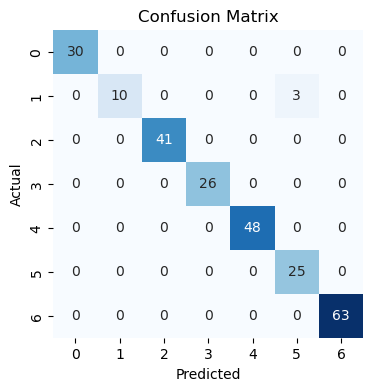



Classification Report:
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        30
    contempt       1.00      0.77      0.87        13
     disgust       1.00      1.00      1.00        41
        fear       1.00      1.00      1.00        26
       happy       1.00      1.00      1.00        48
     sadness       0.89      1.00      0.94        25
    surprise       1.00      1.00      1.00        63

    accuracy                           0.99       246
   macro avg       0.98      0.97      0.97       246
weighted avg       0.99      0.99      0.99       246
 

Macro F1 Score: 0.97 

Micro F1 Score: 0.99 



In [19]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
micro_f1 = f1_score(y_test, y_pred, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

**KNN**

Accuracy: 0.8130081300813008 



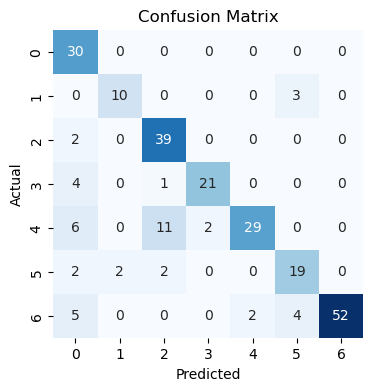



Classification Report:
              precision    recall  f1-score   support

       anger       0.61      1.00      0.76        30
    contempt       0.83      0.77      0.80        13
     disgust       0.74      0.95      0.83        41
        fear       0.91      0.81      0.86        26
       happy       0.94      0.60      0.73        48
     sadness       0.73      0.76      0.75        25
    surprise       1.00      0.83      0.90        63

    accuracy                           0.81       246
   macro avg       0.82      0.82      0.80       246
weighted avg       0.85      0.81      0.81       246
 

Macro F1 Score: 0.80 

Micro F1 Score: 0.81 



In [20]:
accuracy = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
report = classification_report(y_test, y_predict)
macro_f1 = f1_score(y_test, y_predict, average='macro')
micro_f1 = f1_score(y_test, y_predict, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

**Random Forest**

Accuracy: 0.9715447154471545 



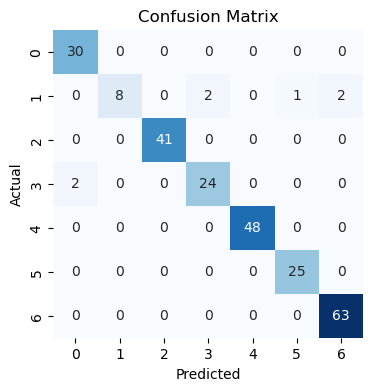



Classification Report:
              precision    recall  f1-score   support

       anger       0.94      1.00      0.97        30
    contempt       1.00      0.62      0.76        13
     disgust       1.00      1.00      1.00        41
        fear       0.92      0.92      0.92        26
       happy       1.00      1.00      1.00        48
     sadness       0.96      1.00      0.98        25
    surprise       0.97      1.00      0.98        63

    accuracy                           0.97       246
   macro avg       0.97      0.93      0.95       246
weighted avg       0.97      0.97      0.97       246
 

Macro F1 Score: 0.95 

Micro F1 Score: 0.97 



In [21]:
accuracy = accuracy_score(y_test, y_prediction)
cm = confusion_matrix(y_test, y_prediction)
report = classification_report(y_test, y_prediction)
macro_f1 = f1_score(y_test, y_prediction, average='macro')
micro_f1 = f1_score(y_test, y_prediction, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

# Classification using LBP Features

**1. SVM**

In [22]:
classifier1 = SVC(kernel='poly', C=10)

classifier1.fit(X_train1, y_train1)

SVC(C=10, kernel='poly')

In [23]:
y_pred1 = classifier1.predict(X_test1)

**2. KNN**

In [24]:
k = 2
knn_classifier1 = KNeighborsClassifier(n_neighbors=k)
knn_classifier1.fit(X_train1, y_train1)

KNeighborsClassifier(n_neighbors=2)

In [25]:
y_predict1 = knn_classifier1.predict(X_test1)

**3. Random Forest**

In [26]:
n_estimators = 100
max_depth= 30
random_forest_classifier1 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
random_forest_classifier1.fit(X_train1, y_train1)

RandomForestClassifier(max_depth=30, random_state=42)

In [27]:
y_prediction1 = random_forest_classifier1.predict(X_test1)

# Evaluate the Classifier for LBP Features

**SVM**

Accuracy: 0.4878048780487805 



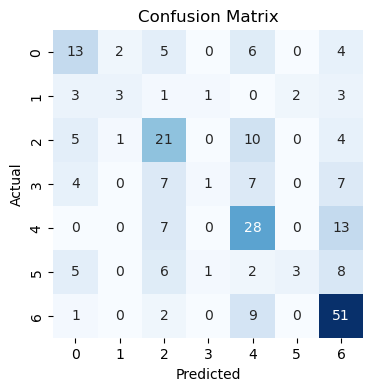



Classification Report:
              precision    recall  f1-score   support

       anger       0.42      0.43      0.43        30
    contempt       0.50      0.23      0.32        13
     disgust       0.43      0.51      0.47        41
        fear       0.33      0.04      0.07        26
       happy       0.45      0.58      0.51        48
     sadness       0.60      0.12      0.20        25
    surprise       0.57      0.81      0.67        63

    accuracy                           0.49       246
   macro avg       0.47      0.39      0.38       246
weighted avg       0.48      0.49      0.44       246
 

Macro F1 Score: 0.38 

Micro F1 Score: 0.49 



In [28]:
accuracy = accuracy_score(y_test1, y_pred1)
cm = confusion_matrix(y_test1, y_pred1)
report = classification_report(y_test1, y_pred1)
macro_f1 = f1_score(y_test1, y_pred1, average='macro')
micro_f1 = f1_score(y_test1, y_pred1, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

**KNN**

Accuracy: 0.7520325203252033 



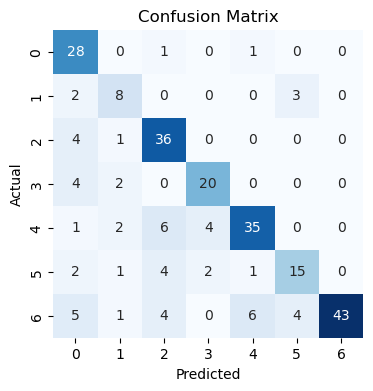



Classification Report:
              precision    recall  f1-score   support

       anger       0.61      0.93      0.74        30
    contempt       0.53      0.62      0.57        13
     disgust       0.71      0.88      0.78        41
        fear       0.77      0.77      0.77        26
       happy       0.81      0.73      0.77        48
     sadness       0.68      0.60      0.64        25
    surprise       1.00      0.68      0.81        63

    accuracy                           0.75       246
   macro avg       0.73      0.74      0.73       246
weighted avg       0.79      0.75      0.75       246
 

Macro F1 Score: 0.73 

Micro F1 Score: 0.75 



In [29]:
accuracy = accuracy_score(y_test1, y_predict1)
cm = confusion_matrix(y_test1, y_predict1)
report = classification_report(y_test1, y_predict1)
macro_f1 = f1_score(y_test1, y_predict1, average='macro')
micro_f1 = f1_score(y_test1, y_predict1, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

**Random Forest**

Accuracy: 0.6951219512195121 



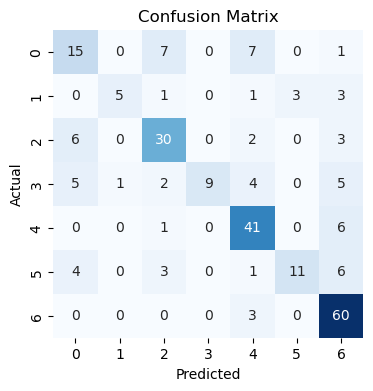



Classification Report:
              precision    recall  f1-score   support

       anger       0.50      0.50      0.50        30
    contempt       0.83      0.38      0.53        13
     disgust       0.68      0.73      0.71        41
        fear       1.00      0.35      0.51        26
       happy       0.69      0.85      0.77        48
     sadness       0.79      0.44      0.56        25
    surprise       0.71      0.95      0.82        63

    accuracy                           0.70       246
   macro avg       0.74      0.60      0.63       246
weighted avg       0.72      0.70      0.68       246
 

Macro F1 Score: 0.63 

Micro F1 Score: 0.70 



In [30]:
accuracy = accuracy_score(y_test1, y_prediction1)
cm = confusion_matrix(y_test1, y_prediction1)
report = classification_report(y_test1, y_prediction1)
macro_f1 = f1_score(y_test1, y_prediction1, average='macro')
micro_f1 = f1_score(y_test1, y_prediction1, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

# Classification using Colour Histograms

**1. SVM**

In [31]:
classifier2 = SVC(kernel='poly', C=10)

classifier2.fit(X_train2, y_train2)

SVC(C=10, kernel='poly')

In [32]:
y_pred2 = classifier2.predict(X_test2)

**2. KNN**

In [33]:
k = 2
knn_classifier2 = KNeighborsClassifier(n_neighbors=k)
knn_classifier2.fit(X_train2, y_train2)

KNeighborsClassifier(n_neighbors=2)

In [34]:
y_predict2 = knn_classifier2.predict(X_test2)

**3. Random Forest**

In [35]:
n_estimators = 100
max_depth= 20
random_forest_classifier2 = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
random_forest_classifier2.fit(X_train2, y_train2)

RandomForestClassifier(max_depth=20, random_state=42)

In [36]:
y_prediction2 = random_forest_classifier2.predict(X_test2)

#  Evaluate the Classifier for Colour Histogram Features

**SVM**

Accuracy: 0.5447154471544715 



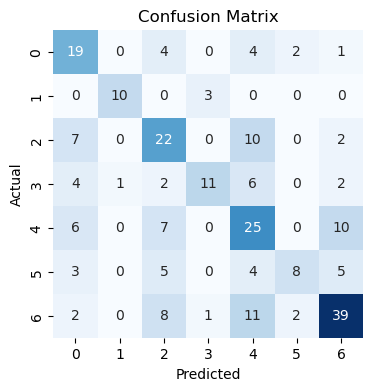



Classification Report:
              precision    recall  f1-score   support

       anger       0.46      0.63      0.54        30
    contempt       0.91      0.77      0.83        13
     disgust       0.46      0.54      0.49        41
        fear       0.73      0.42      0.54        26
       happy       0.42      0.52      0.46        48
     sadness       0.67      0.32      0.43        25
    surprise       0.66      0.62      0.64        63

    accuracy                           0.54       246
   macro avg       0.62      0.55      0.56       246
weighted avg       0.58      0.54      0.55       246
 

Macro F1 Score: 0.56 

Micro F1 Score: 0.54 



In [37]:
accuracy = accuracy_score(y_test2, y_pred2)
cm = confusion_matrix(y_test2, y_pred2)
report = classification_report(y_test2, y_pred2)
macro_f1 = f1_score(y_test2, y_pred2, average='macro')
micro_f1 = f1_score(y_test2, y_pred2, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

**KNN**

Accuracy: 0.7723577235772358 



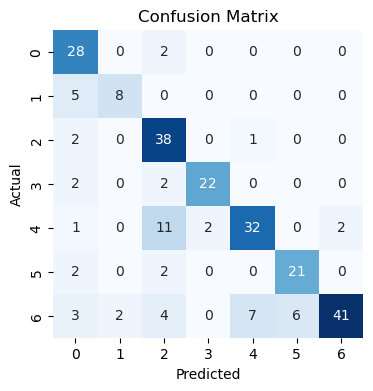



Classification Report:
              precision    recall  f1-score   support

       anger       0.65      0.93      0.77        30
    contempt       0.80      0.62      0.70        13
     disgust       0.64      0.93      0.76        41
        fear       0.92      0.85      0.88        26
       happy       0.80      0.67      0.73        48
     sadness       0.78      0.84      0.81        25
    surprise       0.95      0.65      0.77        63

    accuracy                           0.77       246
   macro avg       0.79      0.78      0.77       246
weighted avg       0.81      0.77      0.77       246
 

Macro F1 Score: 0.77 

Micro F1 Score: 0.77 



In [38]:
accuracy = accuracy_score(y_test2, y_predict2)
cm = confusion_matrix(y_test2, y_predict2)
report = classification_report(y_test2, y_predict2)
macro_f1 = f1_score(y_test2, y_predict2, average='macro')
micro_f1 = f1_score(y_test2, y_predict2, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')

**Random Forest**

Accuracy: 0.9146341463414634 



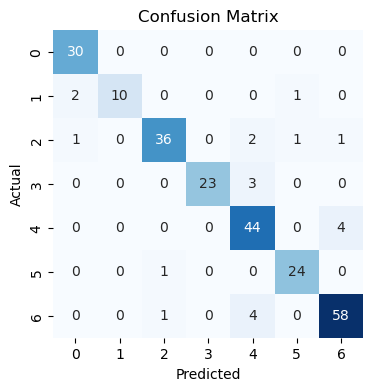



Classification Report:
              precision    recall  f1-score   support

       anger       0.91      1.00      0.95        30
    contempt       1.00      0.77      0.87        13
     disgust       0.95      0.88      0.91        41
        fear       1.00      0.88      0.94        26
       happy       0.83      0.92      0.87        48
     sadness       0.92      0.96      0.94        25
    surprise       0.92      0.92      0.92        63

    accuracy                           0.91       246
   macro avg       0.93      0.90      0.92       246
weighted avg       0.92      0.91      0.91       246
 

Macro F1 Score: 0.92 

Micro F1 Score: 0.91 



In [39]:
accuracy = accuracy_score(y_test2, y_prediction2)
cm = confusion_matrix(y_test2, y_prediction2)
report = classification_report(y_test2, y_prediction2)
macro_f1 = f1_score(y_test2, y_prediction2, average='macro')
micro_f1 = f1_score(y_test2, y_prediction2, average='micro')

print("Accuracy:", accuracy, '\n')

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print('\n')

print("Classification Report:")
print(report, '\n')
print(f"Macro F1 Score: {macro_f1:.2f}", '\n')
print(f"Micro F1 Score: {micro_f1:.2f}", '\n')